# Прогноз оттока клиентов банка

## Предобработка данных

<div style="border:solid gray 2px; padding: 20px">  
    
В этом проекте нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены данные о поведении клиентов и расторжении договоров с банком.  
    Этот проект состоит:  
- **Предобработка данных.**  
- **Подготовка данных к ML.**  
    (Кодировка через OrdinalEncoder, Выделение и масштабирование признаков.  
- **Подбор Гиперпараметров.**  
    Через RandomizedSearchCV и GridSearchCV с прописанием разных гиперпараметров
- **Выбор лучшей модели**.  
    По показателям метрик: f1-меры, auc_roc.  
Лучшей моделью стал RandomForest с учетом дисбаланса классов,  
    f1-мера составила 0.60 на тестовой выборке

### Загрузка библиотек и данных

In [1]:
# Загрузка библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

RANDOM = 12345

In [2]:
# Загрузка данных

pth1 = '/Users/macbookair13i5/Desktop/datasets/Datasets/Churn.csv'
pth2 = '/datasets/Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    display('Something is wrong')
    
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# Приведем к нижнему регистру названия столбцов с добавлением "_" при необходимости

df.columns = [['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']]

In [4]:
# К нижнему регистру привдем значения в столбце "gender"

for gend in df['gender']:
    df[gend] = df[gend].str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (row_number,)        10000 non-null  int64  
 1   (customer_id,)       10000 non-null  int64  
 2   (surname,)           10000 non-null  object 
 3   (credit_score,)      10000 non-null  int64  
 4   (geography,)         10000 non-null  object 
 5   (gender,)            10000 non-null  object 
 6   (age,)               10000 non-null  int64  
 7   (tenure,)            9091 non-null   float64
 8   (balance,)           10000 non-null  float64
 9   (num_of_products,)   10000 non-null  int64  
 10  (has_cr_card,)       10000 non-null  int64  
 11  (is_active_member,)  10000 non-null  int64  
 12  (estimated_salary,)  10000 non-null  float64
 13  (exited,)            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Описание данных

|Название столбца| Описание данных|
|:|:|
|**row_number**| индекс строки в данных|
|**customer_id**| уникальный идентификатор клиента|
|**surname**| фамилия|
|**credit_score**| кредитный рейтинг|
|**geography**| страна проживания|
|**gender**| пол|
|**age**| возраст|
|**tenure**| сколько лет человек является клиентом банка|
|**balance**| баланс на счёте|
|**num_of_products**| количество продуктов банка, используемых клиентом|
|**has_cr_card**| наличие кредитной карты|
|**is_active_member**| активность клиента|
|**estimated_salary**| предполагаемая зарплата|
___
|**Целевой признак**|
|**exited**| факт ухода клиента|


<div style="border:solid gray 2px; padding: 20px">  
    
Обработаем данные:  
    
- Уберем Мультииндекс.  
- Обработаем пропуски.  
- Проверим Дубликаты.  
- Посмотрим на Взаимосвязь признаков

### Изучение данных, Приведение к нужным типам

In [6]:
df.columns

MultiIndex([(      'row_number',),
            (     'customer_id',),
            (         'surname',),
            (    'credit_score',),
            (       'geography',),
            (          'gender',),
            (             'age',),
            (          'tenure',),
            (         'balance',),
            ( 'num_of_products',),
            (     'has_cr_card',),
            ('is_active_member',),
            ('estimated_salary',),
            (          'exited',)],
           )

In [7]:
# Избавимся от мультииндекса

df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [8]:
df = df.drop(['row_number', 'surname', 'customer_id'], axis=1)

### Проверка дубликатов

In [9]:
print(f'Явных дубликатов: {df.duplicated().sum()}')

Явных дубликатов: 0


### Обработка пропусков

In [10]:
# Обработаем пропуски в столбце 'tenure' (Сколько лет человек является клиентом банка)

df_dropna = df.dropna(subset = ['tenure'], axis=0)
df_min = df.fillna(0)
df_median = df.fillna(df['tenure'].median())

print(
    df_dropna.info(),
    df_min.info(),
    df_median.info()
)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_scor

In [11]:
# Посмотрим в каких странах есть клиенты

df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

### Взаимосвязь признаков с целевым

Четкая взаимосвязь с целевым признаком есть в таких признаках как:  

- **credit_score** - Много зслучаев оттока клиентов при низком кредитном рейтинге и при уровне зарплаты выше среднего.   
- **geography** - В Германии отток больше чем где бы то ни было это свойственно для разных значений уровня зарплаты, Во Франции отток происходит только в определенной категории клиентов с определенным показателем зарплаты В Испании - меньше всего.  
- **age** - Отток клиентов чаще всего происходит в Категории клиентов в возрасте от 45 - 60 лет.  
- **num_of_products** - От количества продуктов в банке тоже зависит отток! ЧЕм больше продуктов, тем более вероятен уход клиента. (Если клиент пользуется 3 или 4 продуктами банка, то вероятность  оттока будет максимальной)

---

## Подготовка данных к обучению

**Подготовка данных будет состоять из:**  

- Выделение обучающей, проверочной и тестовой выборок.  
- Кодировка категориальных признаков.  
- Выделение целевого признака.   
- Масштабирование признаков.  

#### Выделение обучающей, проверочной и тестовой выборок

In [12]:
# Разделим данные на обучающую, проверочную и тестовую в соотношении (0.6, 0.2, 0.2)

df_list = [df_dropna, df_min, df_median]

for num, df in enumerate (df_list):
    train, valid = train_test_split(df, test_size = 0.4, stratify = df['exited'], random_state=RANDOM)
    valid, test = train_test_split(valid, test_size = 0.5, stratify = valid['exited'], random_state=RANDOM)
    print()
    if num == 0:
        df_dropna_train = train
        df_dropna_valid = valid
        df_dropna_test = test
    if num == 1:
        df_min_train = train
        df_min_valid = valid
        df_min_test = test
    else:
        df_median_train = train
        df_median_valid = valid
        df_median_test = test

#### Кодировка категориальных признаков. 

In [13]:
# Соберем выборки в списки

df_train = [df_dropna_train, df_min_train, df_median_train]
df_valid = [df_dropna_valid, df_min_valid, df_median_valid]
df_test = [df_dropna_test, df_min_test, df_median_test]

data_encoded = [df_dropna_train, df_min_train, df_median_train, df_dropna_valid, df_min_valid, df_median_valid, df_dropna_test, df_min_test, df_median_test]

In [14]:
# Используем порядковый кодировщик (Обучение на train)

encoder = OrdinalEncoder()

for num, frame in enumerate (data_encoded):
    
    # Обучим кодировщик на наборе обучающих выборок
    if num == 0:
        encoder_0 = encoder
        encoder_0.fit(frame[['geography', 'gender']])
    elif num == 1:
        encoder_1 = encoder
        encoder_1.fit(frame[['geography', 'gender']])
    elif num == 2:
        encoder_2 = encoder
        encoder_2.fit(frame[['geography', 'gender']])
        
    # Закодируем категориальные признаки во всех выборках  
    
    if num in range (0, 8, 3):
        frame[['geography', 'gender']] = encoder_0.transform(frame[['geography', 'gender']])
    elif num in range(1, 9, 3):
        frame[['geography', 'gender']] = encoder_1.transform(frame[['geography', 'gender']])
    elif num in range(2, 10, 3):
        frame[['geography', 'gender']] = encoder_2.transform(frame[['geography', 'gender']])

In [15]:
# Выведем какие категории соответствуют новым значениям

print(encoder.categories_)

[array(['France', 'Germany', 'Spain'], dtype=object), array(['female', 'male'], dtype=object)]


#### Взаимосвязь признаков

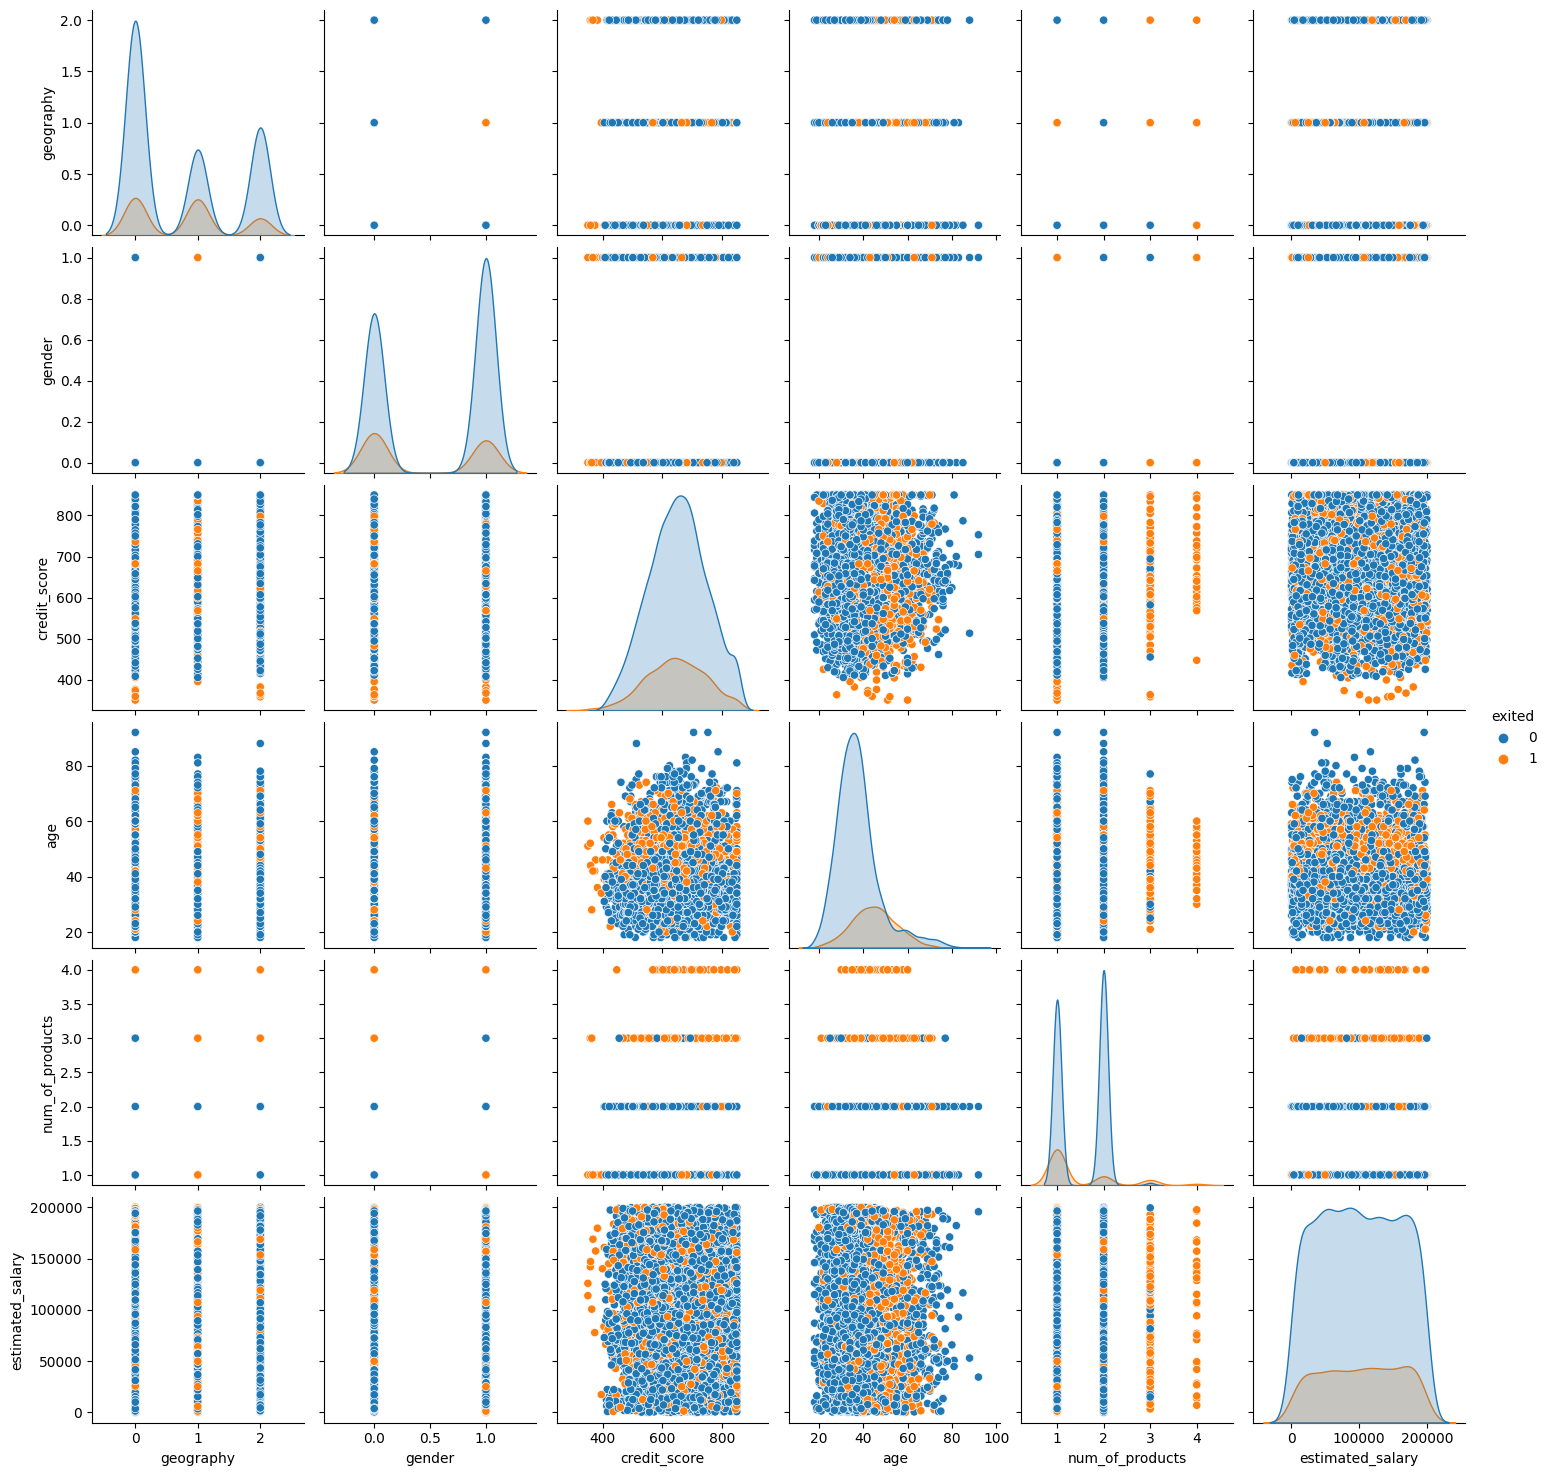

In [16]:

# Посмотрим на одном наборе

sns.pairplot(
    data = df_min_train[['geography', 'gender', 'credit_score', 'age', 'num_of_products', 'estimated_salary', 'exited']],
    hue = 'exited'
)

Четкая взаимосвязь с целевым признаком есть в таких признаках как:  

- **credit_score** - Много зслучаев оттока клиентов при низком кредитном рейтинге и при уровне зарплаты выше среднего.   
- **geography** - В Германии отток больше чем где бы то ни было это свойственно для разных значений уровня зарплаты, Во Франции отток происходит только в определенной категории клиентов с определенным показателем зарплаты В Испании - меньше всего.  
- **age** - Отток клиентов чаще всего происходит в Категории клиентов в возрасте от 45 - 60 лет.  
- **num_of_products** - От количества продуктов в банке тоже зависит отток! Чем больше продуктов, тем более вероятен уход клиента. (Если клиент пользуется 3 и 4 продуктами банка, то вероятность  оттока будет максимальной)

#### Выделение признаков.

In [17]:
# Features, target

# train
features_dropna_train = df_dropna_train.drop(['exited'], axis =1)
target_dropna_train = df_dropna_train['exited']

features_min_train = df_min_train.drop(['exited'], axis =1)
target_min_train = df_min_train['exited']

features_median_train = df_median_train.drop(['exited'], axis =1)
target_median_train = df_median_train['exited']

# valid
features_dropna_valid = df_dropna_valid.drop(['exited'], axis =1)
target_dropna_valid = df_dropna_valid['exited']

features_min_valid = df_min_valid.drop(['exited'], axis =1)
target_min_valid = df_min_valid['exited']

features_median_valid = df_median_valid.drop(['exited'], axis =1)
target_median_valid = df_median_valid['exited']

#test
features_dropna_test = df_dropna_test.drop(['exited'], axis =1)
target_dropna_test = df_dropna_test['exited']

features_min_test = df_min_test.drop(['exited'], axis =1)
target_min_test = df_min_test['exited']

features_median_test = df_median_test.drop(['exited'], axis =1)
target_median_test = df_median_test['exited']

In [18]:
# Выделим списки признаков и целевого признака

features_list = [features_dropna_train, features_min_train, features_median_train, features_dropna_valid, features_min_valid, features_median_valid, features_dropna_test, features_min_test, features_median_test]
target_list = [target_dropna_train, target_min_train, target_median_train, target_dropna_valid, target_min_valid, target_median_valid, target_dropna_test, target_min_test, target_median_test]

Баланс классов:
0    0.796113
1    0.203887
Name: exited, dtype: float64


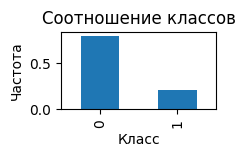


Баланс классов:
0    0.796333
1    0.203667
Name: exited, dtype: float64


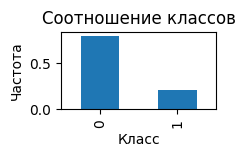


Баланс классов:
0    0.796333
1    0.203667
Name: exited, dtype: float64


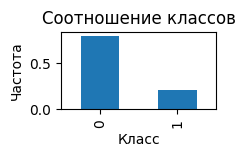


Баланс классов:
0    0.79593
1    0.20407
Name: exited, dtype: float64


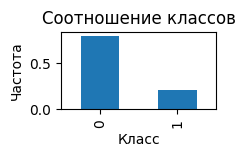


Баланс классов:
0    0.796
1    0.204
Name: exited, dtype: float64


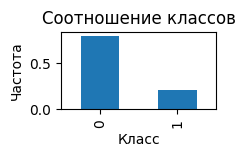


Баланс классов:
0    0.796
1    0.204
Name: exited, dtype: float64


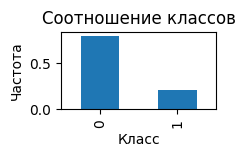


Баланс классов:
0    0.796042
1    0.203958
Name: exited, dtype: float64


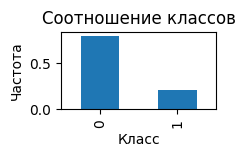


Баланс классов:
0    0.7965
1    0.2035
Name: exited, dtype: float64


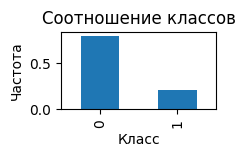


Баланс классов:
0    0.7965
1    0.2035
Name: exited, dtype: float64


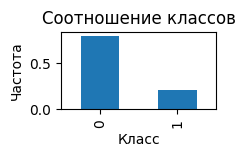

In [19]:
# Проверим дисбаланас

for target in target_list:
    print('Баланс классов:')
    print(target.value_counts(normalize=True))
    target.value_counts(normalize=True).plot(
        kind = 'bar',
        figsize = (2,1),
        title = 'Соотношение классов',
        xlabel = 'Класс',
        ylabel = 'Частота'
    )
    plt.show()
    print()

#### Масштабирование признаков.

In [20]:
# Масштабируем признаки

scaler = StandardScaler()
features_list_scaled = []


for num, frame in enumerate (features_list):
    
    # Обучим Scaler на наборе обучающих выборок
    
    if num == 0:
        scaler_0 = scaler
        scaler_0.fit(frame)
    elif num == 1:
        scaler_1 = scaler
        scaler_1.fit(frame)
    elif num == 2:
        scaler_2 = scaler
        scaler_2.fit(frame)
   
    # Масштабируем признаки
    
    if num in range (0, 8, 3):
        frame = pd.DataFrame(scaler_0.transform(frame), index = frame.index, columns = frame.columns)
        features_list_scaled.append(frame)
        
    elif num in range(1, 9, 3):
        frame = pd.DataFrame(scaler_1.transform(frame), index = frame.index, columns = frame.columns)
        features_list_scaled.append(frame)
    
    elif num in range(2, 10, 3):
        frame = pd.DataFrame(scaler_2.transform(frame), index = frame.index, columns = frame.columns)
        features_list_scaled.append(frame)

In [21]:
features_dropna_train = features_list_scaled[0]
features_min_train = features_list_scaled[1]
features_median_train = features_list_scaled[2]
features_dropna_valid = features_list_scaled[3]
features_min_valid = features_list_scaled[4]
features_median_valid = features_list_scaled[5]
features_dropna_test = features_list_scaled[6]
features_min_test = features_list_scaled[7]
features_median_test = features_list_scaled[8]

features_list = [features_dropna_train, features_min_train, features_median_train, features_dropna_valid, features_min_valid, features_median_valid, features_dropna_test, features_min_test, features_median_test]

#### Выделение Положительного и Отрицательного классов для обучающих выборок.

In [22]:
# Выделим положительный и отрицательный классы в обучающих выборках

# features_dropna_train, target_dropna_train (Пропуски удалены)
features_dropna_zeros = features_dropna_train[target_dropna_train == 0]
features_dropna_ones = features_dropna_train[target_dropna_train == 1]
target_dropna_zeros = target_dropna_train[target_dropna_train == 0]
target_dropna_ones = target_dropna_train[target_dropna_train == 1]

# features_min_train, target_min_train (Пропуски заменены на min)
features_min_zeros = features_min_train[target_min_train == 0]
features_min_ones = features_min_train[target_min_train == 1]
target_min_zeros = target_min_train[target_min_train == 0]
target_min_ones = target_min_train[target_min_train == 1]

# features_median_train, target_median_train (Пропуски заменены на median)
features_median_zeros = features_median_train[target_median_train == 0]
features_median_ones = features_median_train[target_median_train == 1]
target_median_zeros = target_median_train[target_median_train == 0]
target_median_ones = target_median_train[target_median_train == 1]

In [23]:
# Списки выборок 

features_zeros_list = [features_dropna_zeros, features_min_zeros, features_median_zeros]
features_ones_list = [features_dropna_ones, features_min_ones, features_median_ones]
target_zeros_list = [target_dropna_zeros, target_min_zeros, target_median_zeros]
target_ones_list = [target_dropna_ones, target_min_ones, target_median_ones]

In [24]:
# для Upsampling - списки

features_zeros_list_up = features_zeros_list.copy()
features_ones_list_up = features_ones_list.copy()
target_zeros_list_up = target_zeros_list.copy()
target_ones_list_up = target_ones_list.copy()

In [25]:
# Для Downsampling - списки

features_zeros_list_down = features_zeros_list.copy()
features_ones_list_down = features_ones_list.copy()
target_zeros_list_down = target_zeros_list.copy()
target_ones_list_down = target_ones_list.copy()

#### Увеличение Положительного класса для обучающих выборок (Upsampling).

In [26]:
# Увеличим выборки по положительному классу

features_train_up_list = []
target_train_up_list = []

# features
for num, features in enumerate(features_zeros_list_up):
    
    repeat = int(len(target_zeros_list_up[num])/len(target_ones_list_up[num]))
    features = pd.concat([features] + [features_ones_list[num]] * repeat)
     
     # Перемешаем
    features = shuffle(features, random_state = RANDOM)
    features_train_up_list.append(features)

print('Баланс классов:')
# target
for num, target in enumerate(target_zeros_list_up):
    repeat = int(len(target_zeros_list_up[num])/len(target_ones_list_up[num]))
    target = pd.concat([target] + [target_ones_list_up[num]] * repeat)
    
    # Перемешаем
    target = shuffle(target, random_state = RANDOM)
    print(target.value_counts(normalize=True))
    target_train_up_list.append(target)
    

Баланс классов:
0    0.565512
1    0.434488
Name: exited, dtype: float64
0    0.565846
1    0.434154
Name: exited, dtype: float64
0    0.565846
1    0.434154
Name: exited, dtype: float64


In [27]:
# Объявим переменные Upsampling

features_dropna_up = features_train_up_list[0]
features_min_up = features_train_up_list[1]
features_median_up = features_train_up_list[2]

target_dropna_up = target_train_up_list[0]
target_min_up = target_train_up_list[1]
target_median_up = target_train_up_list[2]

#### Уменьшение Отрицательного класса для обучающих выборок (Downsampling).

In [28]:
# Уменьшим выборки по отрицательному классу

features_train_down_list = []
target_train_down_list = []

# features
for num, features in enumerate(features_zeros_list_down):
    
    fraction = len(target_ones_list_down[num])/len(target_zeros_list_down[num])

    features_zeros = features.sample(frac = fraction, replace=True, random_state = RANDOM)
    features = pd.concat([features_zeros, features_ones_list_down[num]]) 
     # Перемешаем
    features = shuffle(features, random_state = RANDOM)
    features_train_down_list.append(features)

# target
for num, target in enumerate(target_zeros_list_down):
    
    fraction = len(target_ones_list_down[num])/len(target_zeros_list_down[num])
    target_zeros = target.sample(frac = fraction, replace = True, random_state = RANDOM)
    target = pd.concat([target_zeros, target_ones_list_down[num]])
    
    # Перемешаем
    target = shuffle(target, random_state = RANDOM)
    target_train_down_list.append(target)
    print(f' Размер отрицательного класса {target_zeros.shape[0]}')
    print(f' Размер положительного класса {target_ones_list_down[num].shape[0]}')
    print(f'Баланс классов: {target.value_counts(normalize=True)}')

 Размер отрицательного класса 1112
 Размер положительного класса 1112
Баланс классов: 1    0.5
0    0.5
Name: exited, dtype: float64
 Размер отрицательного класса 1222
 Размер положительного класса 1222
Баланс классов: 1    0.5
0    0.5
Name: exited, dtype: float64
 Размер отрицательного класса 1222
 Размер положительного класса 1222
Баланс классов: 1    0.5
0    0.5
Name: exited, dtype: float64


In [29]:
# Объявим переменные Downsampling

features_dropna_down = features_train_down_list[0]
features_min_down = features_train_down_list[1]
features_median_down = features_train_down_list[2]

target_dropna_down = target_train_down_list[0]
target_min_down = target_train_down_list[1]
target_median_down = target_train_down_list[2]

---

## Подбор гиперпараметров

In [30]:
# Для взвешивания классов скопируем исходные обучающие выборки

features_dropna_train_balanced = features_dropna_train.copy()
target_dropna_train_balanced = target_dropna_train.copy()
    
features_min_train_balanced = features_min_train.copy()
target_min_train_balanced = target_min_train.copy()
    
features_median_train_balanced = features_median_train.copy()
target_median_train_balanced = target_median_train.copy()

In [31]:
# Соберем все обучающие выборки с разной обработкой пропусков в спсиок списков

# Исходные обучающие выборки
train_list = [
    [features_dropna_train,
    target_dropna_train],
    
    [features_min_train,
    target_min_train],
    
    [features_median_train, 
     target_median_train],

# Upsammpling
    [features_dropna_up,
    target_dropna_up],
    
    [features_min_up,
    target_min_up],
    
    [features_median_up,
     target_median_up],

# Downsampling
    [features_dropna_down,
    target_dropna_down],
    
    [features_min_down,
    target_min_down],
    
    [features_median_down,
    target_median_down],
    
# Balanced
    [features_dropna_train_balanced,
    target_dropna_train_balanced],
    
    [features_min_train_balanced,
    target_min_train_balanced],
    
    [features_median_train_balanced,
    target_median_train_balanced]
]

#### RandomizedSearchCV. 

In [32]:
# Пропишем гиперпараметры для моделей

# DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=RANDOM)
params_tree = {
    'max_depth': range(1,31)
}
# Отдельные словари с class_weight = 'balanced'
params_tree_balanced = {
    'max_depth': range(1,31),
    'class_weight': ['balanced']
}

# RandomForestClassifier
model_forest = RandomForestClassifier(random_state=RANDOM)
params_forest = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 21),
    'max_features': ['log2', 'sqrt', None],
    'min_samples_split': range(1,11),
    'min_samples_leaf': range(1,11),
    'bootstrap': [True, False]
}
# Отдельные словари с class_weight = 'balanced'
params_forest_balanced = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 21),
    'max_features': ['log2', 'sqrt', None],
    'min_samples_split': range(1,11),
    'min_samples_leaf': range(1,11),
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}
# LogisticRegression
model_logistic = LogisticRegression(random_state=RANDOM)
params_logistic = {
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': range(100, 1000, 100),
}
# Отдельные словари с class_weight = 'balanced'
params_logistic_balanced = {
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': range(100, 1000, 100),
    'class_weight': ['balanced']
}

#### DecisionTree.

In [33]:
# Поиск лучших гиперпараметров

print('Лучшие гиперпараметры для DecisionTree:')
for num, train in enumerate(train_list):
    print()
    if num == 0:
        print('Исходные выборки')
        print()
    if num == 3:
        print()
        print('Upsampling')
        print()
    if num == 6:
        print()
        print('Downsampling')
        print()
    if num == 9:
        print()
        print('Balanced')
        print()
        
        
    if num in range (0, 11, 3):
        print('С удалением пропусков:')
    elif num in range(1, 12, 3):
        print('С заменой проспусков на min():')
    elif num in range(2, 13, 3):
        print('С заменой проспусков на median():')
    
    if num in range (0, 8, 3):
        rs_tree = RandomizedSearchCV(model_tree, params_tree, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_tree.fit(train[0],train[1])
        print(f'Лучшие параметры Дерева: {rs_tree.best_params_}')
        
    elif num in range(1, 9, 3):
        rs_tree = RandomizedSearchCV(model_tree, params_tree, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_tree.fit(train[0],train[1])
        print(f'Лучшие параметры Дерева: {rs_tree.best_params_}')
        
    elif num in range(2, 10, 3):
        rs_tree = RandomizedSearchCV(model_tree, params_tree, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_tree.fit(train[0],train[1])
        print(f'Лучшие параметры Дерева: {rs_tree.best_params_}')
        
    elif num in range(9, 13): # Параметры с class_weight = balanced
        rs_tree = RandomizedSearchCV(model_tree, params_tree_balanced, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_tree.fit(train[0],train[1])
        print(f'Лучшие параметры Дерева: {rs_tree.best_params_}')

Лучшие гиперпараметры для DecisionTree:

Исходные выборки

С удалением пропусков:
Лучшие параметры Дерева: {'max_depth': 9}

С заменой проспусков на min():
Лучшие параметры Дерева: {'max_depth': 4}

С заменой проспусков на median():
Лучшие параметры Дерева: {'max_depth': 4}


Upsampling

С удалением пропусков:
Лучшие параметры Дерева: {'max_depth': 19}

С заменой проспусков на min():
Лучшие параметры Дерева: {'max_depth': 19}

С заменой проспусков на median():
Лучшие параметры Дерева: {'max_depth': 22}


Downsampling

С удалением пропусков:
Лучшие параметры Дерева: {'max_depth': 4}

С заменой проспусков на min():
Лучшие параметры Дерева: {'max_depth': 4}

С заменой проспусков на median():
Лучшие параметры Дерева: {'max_depth': 4}


Balanced

С удалением пропусков:
Лучшие параметры Дерева: {'max_depth': 9, 'class_weight': 'balanced'}

С заменой проспусков на min():
Лучшие параметры Дерева: {'max_depth': 9, 'class_weight': 'balanced'}

С заменой проспусков на median():
Лучшие параметры Д

#### RandomForest.

<div class="alert alert-block alert-info">

<b>Комментарий студента:</b> Оставлю закомментированным код в следущей ячейке. Код выполнялся !!!**Очень долго**(Wall time: 18min 48s).  

Лучшие параметры, полученные в процессе работы RandomizedSearchCV на RandomForest сохраню в отдельной ячейке для последующего использования.
</div>

In [34]:
#%%time
# Закомментирую ячейку так как код выполнялся очень долго (Wall time: 18min 48s)!
# Параметры найденные RSCV запишу в список словарей

# for num, train in enumerate(train_list):
#     print()
#     if num == 0:
#         print('Исходные выборки')
#         print()
#     if num == 3:
#         print()
#         print('Upsampling')
#         print()
#     if num == 6:
#         print()
#         print('Downsampling')
#         print()
#     if num == 9:
#         print()
#         print('Balanced')
#         print()
#         
#         
#     if num in range (0, 10, 3):
#         print('С удалением пропусков:')
#     elif num in range(1, 11, 3):
#         print('С заменой проспусков на min():')
#     elif num in range(2, 12, 3):
#         print('С заменой проспусков на median():')
#         
#     if num in range (0, 8, 3):
#         rs_forest = RandomizedSearchCV(model_forest, params_forest, cv=3, scoring = 'f1', random_state=RANDOM)
#         rs_forest.fit(train[0],train[1])
#         print(f'Лучшие параметры Леса: {rs_forest.best_params_}')
#         
#     elif num in range(1, 9, 3):        
#         rs_forest = RandomizedSearchCV(model_forest, params_forest, cv=3, scoring = 'f1', random_state=RANDOM)
#         rs_forest.fit(train[0],train[1])
#         print(f'Лучшие параметры Леса: {rs_forest.best_params_}')
#         
#     elif num in range(2, 10, 3):
#         rs_forest = RandomizedSearchCV(model_forest, params_forest, cv=3, scoring = 'f1', random_state=RANDOM)
#         rs_forest.fit(train[0],train[1])
#         print(f'Лучшие параметры Леса: {rs_forest.best_params_}')
#         
#     elif num in range(9, 12): # Параметры с class_weight = balanced
#         rs_forest = RandomizedSearchCV(model_forest, params_forest_balanced, cv=3, scoring = 'f1', random_state=RANDOM)
#         rs_forest.fit(train[0],train[1])
#         print(f'Лучшие параметры Леса: {rs_forest.best_params_}')

In [35]:
# Лучшие гиперпараметры для RandomForest

best_params_forest_list = [
# Исходные выборки    
    {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 18, 'bootstrap': True},
    {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'bootstrap': True},
    {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'bootstrap': True},
    
# Upsampling
    {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 18, 'bootstrap': True},
    {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 18, 'bootstrap': True},
    {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 18, 'bootstrap': True},

# Downsampling
    {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'bootstrap': True},
    {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'bootstrap': True},
    {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 18, 'bootstrap': True},

# Balanced
    {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 9, 'class_weight': 'balanced', 'bootstrap': False},
    {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'class_weight': 'balanced', 'bootstrap': True},
    {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 11, 'class_weight': 'balanced', 'bootstrap': True}
]

#### LogisticRegression.

In [36]:
for num, train in enumerate(train_list):
    print()
    if num == 0:
        print('Исходные выборки')
        print()
    if num == 3:
        print()
        print('Upsampling')
        print()
    if num == 6:
        print()
        print('Downsampling')
        print()
    if num == 9:
        print()
        print('Balanced')
        print()
        
        
    if num in range (0, 11, 3):
        print('С удалением пропусков:')
    elif num in range(1, 12, 3):
        print('С заменой проспусков на min():')
    elif num in range(2, 13, 3):
        print('С заменой проспусков на median():')

    if num in range (0, 8, 3):        
        rs_logistic = RandomizedSearchCV(model_logistic, params_logistic, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_logistic.fit(train[0], train[1])
        print(f'Лучшие параметры logistic: {rs_logistic.best_params_}')
        
    elif num in range(1, 9, 3): 
        rs_logistic = RandomizedSearchCV(model_logistic, params_logistic, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_logistic.fit(train[0],train[1])
        print(f'Лучшие параметры logistic: {rs_logistic.best_params_}')
        
    elif num in range(2, 10, 3):        
        rs_logistic = RandomizedSearchCV(model_logistic, params_logistic, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_logistic.fit(train[0],train[1])
        print(f'Лучшие параметры logistic: {rs_logistic.best_params_}')
        
    elif num in range(9, 13): # Параметры с class_weight = balanced
        rs_logistic = RandomizedSearchCV(model_logistic, params_logistic_balanced, cv=3, scoring = 'f1', random_state=RANDOM)
        rs_logistic.fit(train[0],train[1])
        print(f'Лучшие параметры logistic: {rs_logistic.best_params_}')
        


Исходные выборки

С удалением пропусков:
Лучшие параметры logistic: {'solver': 'liblinear', 'max_iter': 100}

С заменой проспусков на min():
Лучшие параметры logistic: {'solver': 'liblinear', 'max_iter': 100}

С заменой проспусков на median():
Лучшие параметры logistic: {'solver': 'lbfgs', 'max_iter': 600}


Upsampling

С удалением пропусков:
Лучшие параметры logistic: {'solver': 'lbfgs', 'max_iter': 600}

С заменой проспусков на min():
Лучшие параметры logistic: {'solver': 'lbfgs', 'max_iter': 600}

С заменой проспусков на median():
Лучшие параметры logistic: {'solver': 'liblinear', 'max_iter': 100}


Downsampling

С удалением пропусков:
Лучшие параметры logistic: {'solver': 'liblinear', 'max_iter': 100}

С заменой проспусков на min():
Лучшие параметры logistic: {'solver': 'lbfgs', 'max_iter': 600}

С заменой проспусков на median():
Лучшие параметры logistic: {'solver': 'lbfgs', 'max_iter': 600}


Balanced

С удалением пропусков:
Лучшие параметры logistic: {'solver': 'lbfgs', 'max_it

---

## Выбор лучшей модели

#### Работа с Дисбалансом. Модели на разных выборках

In [37]:
# Валидационные выборки

valid_list = [
    [features_dropna_valid,
    target_dropna_valid],

    [features_min_valid,
    target_min_valid],
    
    [features_median_valid,
    target_median_valid],
]

In [38]:
# Соберем все гиперпараметры

# DecisionTreeClassifier
best_params_tree_list = [
# Исходные выборки 
    {'max_depth': [9]},
    {'max_depth': [4]},
    {'max_depth': [4]},
    
# Upsampling
    {'max_depth': [19]},
    {'max_depth': [19]},
    {'max_depth': [22]},
    
# Downsampling    
    {'max_depth': [4]},
    {'max_depth': [4]},
    {'max_depth': [4]},
    
# Balanced    
    {'max_depth': [9], 'class_weight': ['balanced']},
    {'max_depth': [9], 'class_weight': ['balanced']},
    {'max_depth': [9], 'class_weight': ['balanced']}
]

# RandomForest
best_params_forest_list = [
# Исходные выборки    
    {'n_estimators': [300], 'min_samples_split': [10], 'min_samples_leaf': [2], 'max_features': [None], 'max_depth': [18], 'bootstrap': [True]},
    {'n_estimators': [700], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [11], 'bootstrap': [True]},
    {'n_estimators': [700], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [11], 'bootstrap': [True]},
    
# Upsampling
    {'n_estimators': [300], 'min_samples_split': [10], 'min_samples_leaf': [2], 'max_features': [None], 'max_depth': [18], 'bootstrap': [True]},
    {'n_estimators': [300], 'min_samples_split': [10], 'min_samples_leaf': [2], 'max_features': [None], 'max_depth': [18], 'bootstrap': [True]},
    {'n_estimators': [300], 'min_samples_split': [10], 'min_samples_leaf': [2], 'max_features': [None], 'max_depth': [18], 'bootstrap': [True]},

# Downsampling
    {'n_estimators': [700], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [11], 'bootstrap': [True]},
    {'n_estimators': [700], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [11], 'bootstrap': [True]},
    {'n_estimators': [300], 'min_samples_split': [10], 'min_samples_leaf': [2], 'max_features': [None], 'max_depth': [18], 'bootstrap': [True]},

# Balanced
    {'n_estimators': [300], 'min_samples_split': [8], 'min_samples_leaf': [9], 'max_features': ['sqrt'], 'max_depth': [9], 'class_weight': ['balanced'], 'bootstrap': [False]},
    {'n_estimators': [700], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [11], 'class_weight': ['balanced'], 'bootstrap': [True]},
    {'n_estimators': [700], 'min_samples_split': [2], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [11], 'class_weight': ['balanced'], 'bootstrap': [True]}
]

# LogisticRegression
best_params_logistic_list =[
# Исходные выборки    
    {'solver': ['liblinear'], 'max_iter': [100]},
    {'solver': ['liblinear'], 'max_iter': [100]},
    {'solver': ['lbfgs'], 'max_iter': [600]},

# Upsampling
    {'solver': ['lbfgs'], 'max_iter': [600]},
    {'solver': ['lbfgs'], 'max_iter': [600]},
    {'solver': ['liblinear'], 'max_iter': [100]},

# Downsampling
    {'solver': ['liblinear'], 'max_iter': [100]},
    {'solver': ['lbfgs'], 'max_iter': [600]},
    {'solver': ['lbfgs'], 'max_iter': [600]},
    
# Balanced
    {'solver': ['lbfgs'], 'max_iter': [600], 'class_weight': ['balanced']},
    {'solver': ['lbfgs'], 'max_iter': [600], 'class_weight': ['balanced']},
    {'solver': ['lbfgs'], 'max_iter': [600], 'class_weight': ['balanced']}
]


Используем GridSearchCV
    
- В GridSearchCV пропишем параметр scoring = 'f1'  
- Добавим расчет roc_auc_score  
- Проверим class_weight = 'balanced'


In [39]:
# DecisionTree (лучший набор данных )

# Список для добавления лучших моделей
best_models = []

# Список для добавления обозначений лучшей обработки пропусков


best_f1_tree = 0
best_auc_tree = 0

for num, train in enumerate(train_list):
    print()
    
    if num == 0:
        name = 'Исходные выборки:'
        print(name)
        print('-'*25)
        
        
    elif num == 3:
        name = 'Upsampling:'
        print(name)
        print('-'*25)
        
    elif num == 6:
        name = 'Downsampling:'
        print(name)
        print('-'*25)
        
    elif num == 9: 
        name = 'Balanced:'
        print(name)
        print('-'*25)
        
    if num in range (0, 10, 3):
        type_nan = 'С удалением пропусков:'
        print(type_nan)
        
    elif num in range(1, 11, 3):
        type_nan = 'С заменой проспусков на min():'
        print(type_nan)
        
    elif num in range(2, 12, 3):
        type_nan = 'С заменой проспусков на median():'
        print(type_nan)
        
    if num in range (0, 10, 3):
        grid_tree = GridSearchCV(model_tree, best_params_tree_list[num], cv=3)
        grid_tree.fit(train[0], train[1])
        grid_tree_pred = grid_tree.predict(valid_list[0][0])
        f1_grid_tree = f1_score(valid_list[0][1], grid_tree_pred)
        # Вероятности классов
        model_prob = grid_tree.predict_proba(valid_list[0][0])
        model_prob_one = model_prob[:,1]
        auc_roc_tree = roc_auc_score(valid_list[0][1], model_prob_one)
        print(f'F1-мера: {f1_grid_tree}')
        print(f'AUC: {auc_roc_tree}')
        if (f1_grid_tree > best_f1_tree):
            best_grid_tree = grid_tree
            best_f1_tree = f1_grid_tree
            best_auc_tree = auc_roc_tree
            best_name = name
            best_type_nan = type_nan
        
    elif num in range(1, 11, 3):

        grid_tree = GridSearchCV(model_tree, best_params_tree_list[num], cv=3)
        grid_tree.fit(train[0], train[1])
        grid_tree_pred = grid_tree.predict(valid_list[1][0])
        f1_grid_tree = f1_score(valid_list[1][1], grid_tree_pred)
        # Вероятности классов
        model_prob = grid_tree.predict_proba(valid_list[1][0])
        model_prob_one = model_prob[:,1]
        auc_roc_tree = roc_auc_score(valid_list[1][1], model_prob_one)
        print(f'F1-мера: {f1_grid_tree}')
        print(f'AUC: {auc_roc_tree}')
        if (f1_grid_tree > best_f1_tree):
            best_grid_tree = grid_tree
            best_f1_tree = f1_grid_tree
            best_name = name
            best_type_nan = type_nan
            best_auc_tree = auc_roc_tree
        
    elif num in range(2, 12, 3):

        grid_tree = GridSearchCV(model_tree, best_params_tree_list[num], cv=3)
        grid_tree.fit(train[0], train[1])
        grid_tree_pred = grid_tree.predict(valid_list[2][0])
        f1_grid_tree = f1_score(valid_list[2][1], grid_tree_pred)
        # Вероятности классов
        model_prob = grid_tree.predict_proba(valid_list[1][0])
        model_prob_one = model_prob[:,1]
        auc_roc_tree = roc_auc_score(valid_list[1][1], model_prob_one)
        print(f'F1-мера: {f1_grid_tree}')
        print(f'AUC: {auc_roc_tree}')
        if (f1_grid_tree > best_f1_tree):
            best_grid_tree = grid_tree
            best_f1_tree = f1_grid_tree
            best_name = name
            best_type_nan = type_nan
            best_auc_tree = auc_roc_tree
            
best_models.append(best_grid_tree)

print()            
print('-'*25)
print('Лучшие показатели модели:')
print(f'Лучшие гиперпараметры: {best_grid_tree.best_params_}')
print(f'Обучающие данные: {best_name}')
print(f'Обработка пропусков: {best_type_nan}')
print(f'f1-мера: {best_f1_tree}')
print(f'AUC: {best_auc_tree}')



Исходные выборки:
-------------------------
С удалением пропусков:
F1-мера: 0.5421487603305786
AUC: 0.7834007343011007

С заменой проспусков на min():
F1-мера: 0.5206349206349208
AUC: 0.8198921999704405

С заменой проспусков на median():
F1-мера: 0.5206349206349208
AUC: 0.8198921999704405

Upsampling:
-------------------------
С удалением пропусков:
F1-мера: 0.4862023653088041
AUC: 0.679683963661223

С заменой проспусков на min():
F1-мера: 0.5504151838671411
AUC: 0.7230599997536703

С заменой проспусков на median():
F1-мера: 0.5373493975903614
AUC: 0.7145939563011134

Downsampling:
-------------------------
С удалением пропусков:
F1-мера: 0.5210384959713519
AUC: 0.8271989449311431

С заменой проспусков на min():
F1-мера: 0.5637707948243993
AUC: 0.8248649805399547

С заменой проспусков на median():
F1-мера: 0.5637707948243993
AUC: 0.8248141750418759

Balanced:
-------------------------
С удалением пропусков:
F1-мера: 0.5326530612244897
AUC: 0.7818993474741868

С заменой проспусков на m

In [40]:
%%time
# RandomForest (лучший набор данных )

best_f1_forest = 0
best_auc_forest = 0
for num, train in enumerate(train_list):
    print()
    
    if num == 0:
        name = 'Исходные выборки:'
        print(name)
        print('-'*25)
        
        
    elif num == 3:
        name = 'Upsampling:'
        print(name)
        print('-'*25)
        
    elif num == 6:
        name = 'Downsampling:'
        print(name)
        print('-'*25)
        
    elif num == 9: 
        name = 'Balanced:'
        print(name)
        print('-'*25)
        
    if num in range (0, 10, 3):
        type_nan = 'С удалением пропусков:'
        print(type_nan)
        
    elif num in range(1, 11, 3):
        type_nan = 'С заменой проспусков на min():'
        print(type_nan)
        
    elif num in range(2, 12, 3):
        type_nan = 'С заменой проспусков на median():'
        print(type_nan)
        
    if num in range (0, 10, 3):
        grid_forest = GridSearchCV(model_forest, best_params_forest_list[num], cv=3)
        grid_forest.fit(train[0], train[1])
        grid_forest_pred = grid_forest.predict(valid_list[0][0])
        f1_grid_forest = f1_score(valid_list[0][1], grid_forest_pred)
        # Вероятности классов
        model_prob = grid_forest.predict_proba(valid_list[0][0])
        model_prob_one = model_prob[:,1]
        auc_roc_forest = roc_auc_score(valid_list[0][1], model_prob_one)
        print(f'F1-мера: {f1_grid_forest}')
        print(f'AUC: {auc_roc_forest}')
        if f1_grid_forest > best_f1_forest:
            best_grid_forest = grid_forest
            best_f1_forest = f1_grid_forest
            best_auc_forest = auc_roc_forest
            best_name = name
            best_type_nan = type_nan
        
    elif num in range(1, 11, 3):

        grid_forest = GridSearchCV(model_forest, best_params_forest_list[num], cv=3)
        grid_forest.fit(train[0], train[1])
        grid_forest_pred = grid_forest.predict(valid_list[1][0])
        f1_grid_forest = f1_score(valid_list[1][1], grid_forest_pred)
        # Вероятности классов
        model_prob = grid_forest.predict_proba(valid_list[1][0])
        model_prob_one = model_prob[:,1]
        auc_roc_forest = roc_auc_score(valid_list[1][1], model_prob_one)
        print(f'F1-мера: {f1_grid_forest}')
        print(f'AUC: {auc_roc_forest}')
        if f1_grid_forest > best_f1_forest:
            best_grid_forest = grid_forest
            best_f1_forest = f1_grid_forest
            best_auc_forest = auc_roc_forest
            best_name = name
            best_type_nan = type_nan
        
    elif num in range(2, 12, 3):
        grid_forest = GridSearchCV(model_forest, best_params_forest_list[num], cv=3)
        grid_forest.fit(train[0], train[1])
        grid_forest_pred = grid_forest.predict(valid_list[2][0])
        f1_grid_forest = f1_score(valid_list[2][1], grid_forest_pred)
        # Вероятности классов
        model_prob = grid_forest.predict_proba(valid_list[2][0])
        model_prob_one = model_prob[:,1]
        auc_roc_forest = roc_auc_score(valid_list[2][1], model_prob_one)
        print(f'F1-мера: {f1_grid_forest}')
        print(f'AUC: {auc_roc_forest}')
        if f1_grid_forest > best_f1_forest:
            best_f1_forest = f1_grid_forest
            best_grid_forest = grid_forest
            best_auc_forest = auc_roc_forest
            best_name = name
            best_type_nan = type_nan
            
best_models.append(best_grid_forest)

print()            
print('-'*25)
print('Лучшие показатели модели:')
print(f'Лучшие гиперпараметры: {best_grid_forest.best_params_}')
print(f'Обучающие данные: {best_name}')
print(f'Обработка пропусков: {best_type_nan}')
print(f'f1-мера: {best_f1_forest}')
print(f'AUC: {best_auc_forest}')


Исходные выборки:
-------------------------
С удалением пропусков:
F1-мера: 0.5880452342487884
AUC: 0.8607053910218557

С заменой проспусков на min():
F1-мера: 0.5777080062794349
AUC: 0.8718084909843333

С заменой проспусков на median():
F1-мера: 0.573208722741433
AUC: 0.8708893733372747

Upsampling:
-------------------------
С удалением пропусков:
F1-мера: 0.6273458445040214
AUC: 0.8515284900258365

С заменой проспусков на min():
F1-мера: 0.6111801242236025
AUC: 0.8557285508424475

С заменой проспусков на median():
F1-мера: 0.6104218362282878
AUC: 0.8534423034289094

Downsampling:
-------------------------
С удалением пропусков:
F1-мера: 0.5877632898696089
AUC: 0.8704355325732017

С заменой проспусков на min():
F1-мера: 0.6025878003696858
AUC: 0.8724227756429204

С заменой проспусков на median():
F1-мера: 0.5872727272727273
AUC: 0.8643870393634842

Balanced:
-------------------------
С удалением пропусков:
F1-мера: 0.6212471131639722
AUC: 0.8729502623701421

С заменой проспусков на m

In [41]:
# LogisticRegression (лучший набор данных)

best_f1_logistic = 0
best_auc_logistic = 0

for num, train in enumerate(train_list):
    print()
    
    if num == 0:
        name = 'Исходные выборки:'
        print(name)
        print('-'*25)
        
        
    elif num == 3:
        name = 'Upsampling:'
        print(name)
        print('-'*25)
        
    elif num == 6:
        name = 'Downsampling:'
        print(name)
        print('-'*25)
        
    elif num == 9: 
        name = 'Balanced:'
        print(name)
        print('-'*25)
        
    if num in range (0, 10, 3):
        type_nan = 'С удалением пропусков:'
        print(type_nan)
        
    elif num in range(1, 11, 3):
        type_nan = 'С заменой проспусков на min():'
        print(type_nan)
        
    elif num in range(2, 12, 3):
        type_nan = 'С заменой проспусков на median():'
        print(type_nan)
        
    if num in range (0, 10, 3):
        grid_logistic = GridSearchCV(model_logistic, best_params_logistic_list[num], cv=3)
        grid_logistic.fit(train[0], train[1])
        grid_logistic_pred = grid_logistic.predict(valid_list[0][0])
        f1_grid_logistic = f1_score(valid_list[0][1], grid_logistic_pred)
        # Вероятности классов
        model_prob = grid_logistic.predict_proba(valid_list[0][0])
        model_prob_one = model_prob[:,1]
        auc_roc_logistic = roc_auc_score(valid_list[0][1], model_prob_one)
        print(f'F1-мера: {f1_grid_logistic}')
        print(f'AUC: {auc_roc_logistic}')
        if (f1_grid_logistic > best_f1_logistic):
            best_grid_logistic = grid_logistic
            best_f1_logistic = f1_grid_logistic
            best_auc_logistic = auc_roc_logistic
            best_name = name
            best_type_nan = type_nan
        
    elif num in range(1, 11, 3):

        grid_logistic = GridSearchCV(model_logistic, best_params_logistic_list[num], cv=3)
        grid_logistic.fit(train[0], train[1])
        grid_logistic_pred = grid_logistic.predict(valid_list[1][0])
        f1_grid_logistic = f1_score(valid_list[1][1], grid_logistic_pred)
        # Вероятности классов
        model_prob = grid_logistic.predict_proba(valid_list[1][0])
        model_prob_one = model_prob[:,1]
        auc_roc_logistic = roc_auc_score(valid_list[1][1], model_prob_one)
        print(f'F1-мера: {f1_grid_logistic}')
        print(f'AUC: {auc_roc_logistic}')
        if (f1_grid_logistic > best_f1_logistic):
            best_grid_logistic = grid_logistic
            best_f1_logistic = f1_grid_logistic
            best_name = name
            best_type_nan = type_nan
            best_auc_logistic = auc_roc_logistic
        
    elif num in range(2, 12, 3):

        grid_logistic = GridSearchCV(model_logistic, best_params_logistic_list[num], cv=3)
        grid_logistic.fit(train[0], train[1])
        grid_logistic_pred = grid_logistic.predict(valid_list[2][0])
        f1_grid_logistic = f1_score(valid_list[2][1], grid_logistic_pred)
        # Вероятности классов
        model_prob = grid_logistic.predict_proba(valid_list[2][0])
        model_prob_one = model_prob[:,1]
        auc_roc_logistic = roc_auc_score(valid_list[2][1], model_prob_one)
        print(f'F1-мера: {f1_grid_logistic}')
        print(f'AUC: {auc_roc_logistic}')
        if (f1_grid_logistic > best_f1_logistic):
            best_grid_logistic = grid_logistic
            best_f1_logistic = f1_grid_logistic
            best_name = name
            best_type_nan = type_nan
            best_auc_logistic = auc_roc_logistic
            
best_models.append(best_grid_logistic)

print()            
print('-'*25)
print('Лучшие показатели модели:')
print(f'Лучшие гиперпараметры: {best_grid_logistic.best_params_}')
print(f'Обучающие данные: {best_name}')
print(f'Обработка пропусков: {best_type_nan}')
print(f'f1-мера: {best_f1_logistic}')
print(f'AUC: {best_auc_logistic}')




Исходные выборки:
-------------------------
С удалением пропусков:
F1-мера: 0.2719665271966527
AUC: 0.7742722651382078

С заменой проспусков на min():
F1-мера: 0.2438095238095238
AUC: 0.7736584269386146

С заменой проспусков на median():
F1-мера: 0.2438095238095238
AUC: 0.7735983840772489

Upsampling:
-------------------------
С удалением пропусков:
F1-мера: 0.5038674033149172
AUC: 0.7768167991401487

С заменой проспусков на min():
F1-мера: 0.5050709939148073
AUC: 0.7793163119519165

С заменой проспусков на median():
F1-мера: 0.5045778229908443
AUC: 0.7793178515124642

Downsampling:
-------------------------
С удалением пропусков:
F1-мера: 0.4783010156971376
AUC: 0.7732384317772434

С заменой проспусков на min():
F1-мера: 0.5025728987993139
AUC: 0.7798089713272244

С заменой проспусков на median():
F1-мера: 0.5025641025641027
AUC: 0.7794887427332742

Balanced:
-------------------------
С удалением пропусков:
F1-мера: 0.49067164179104483
AUC: 0.7771819006514082

С заменой проспусков на

#### Пороговые значения классификации.

In [42]:
best_models = [best_grid_tree, best_grid_forest, best_grid_logistic]

Модель DecisionTree:
Порог: 0.2, значение f1-меры: 0.4014
Порог: 0.3, значение f1-меры: 0.4547
Порог: 0.4, значение f1-меры: 0.5665
Порог: 0.5, значение f1-меры: 0.5638
Порог: 0.6, значение f1-меры: 0.5696
Порог: 0.7, значение f1-меры: 0.5258
Порог: 0.8, значение f1-меры: 0.5258
Лучшее значение f1-меры: 0.5695931477516061, лучший порог: 0.6
Площадь под кривой:, 0.8248649805399547


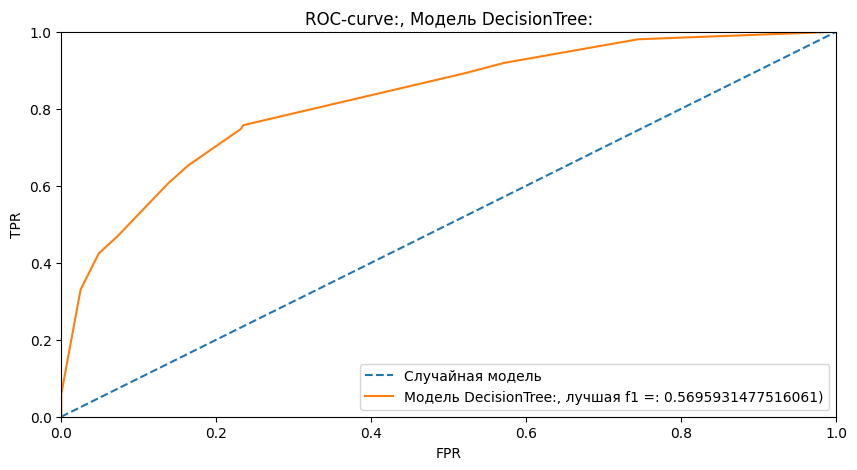

-------------------------
Модель RandomForest:
Порог: 0.2, значение f1-меры: 0.5003
Порог: 0.3, значение f1-меры: 0.5770
Порог: 0.4, значение f1-меры: 0.6527
Порог: 0.5, значение f1-меры: 0.6366
Порог: 0.6, значение f1-меры: 0.5871
Порог: 0.7, значение f1-меры: 0.5466
Порог: 0.8, значение f1-меры: 0.4691
Лучшее значение f1-меры: 0.6527196652719665, лучший порог: 0.4
Площадь под кривой:, 0.8705091018819588


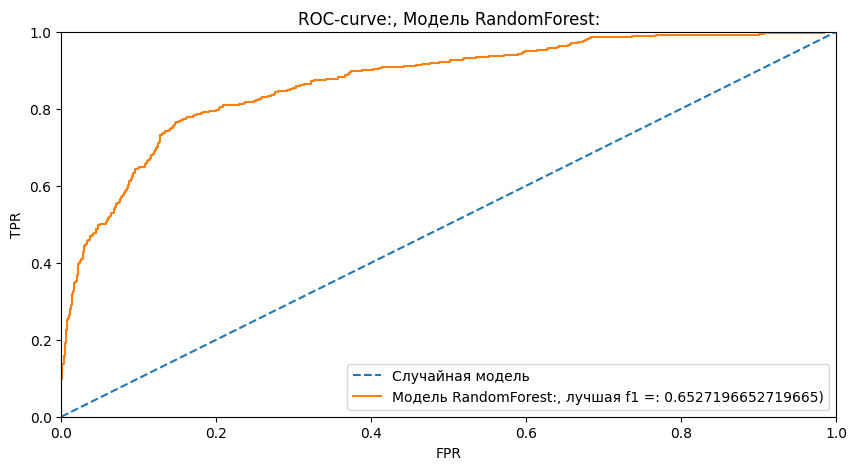

-------------------------
Модель LogisticRegression:
Порог: 0.2, значение f1-меры: 0.3735
Порог: 0.3, значение f1-меры: 0.4239
Порог: 0.4, значение f1-меры: 0.4689
Порог: 0.5, значение f1-меры: 0.5052
Порог: 0.6, значение f1-меры: 0.4890
Порог: 0.7, значение f1-меры: 0.4429
Порог: 0.8, значение f1-меры: 0.2472
Лучшее значение f1-меры: 0.5051546391752577, лучший порог: 0.5
Площадь под кривой:, 0.7803893856537589


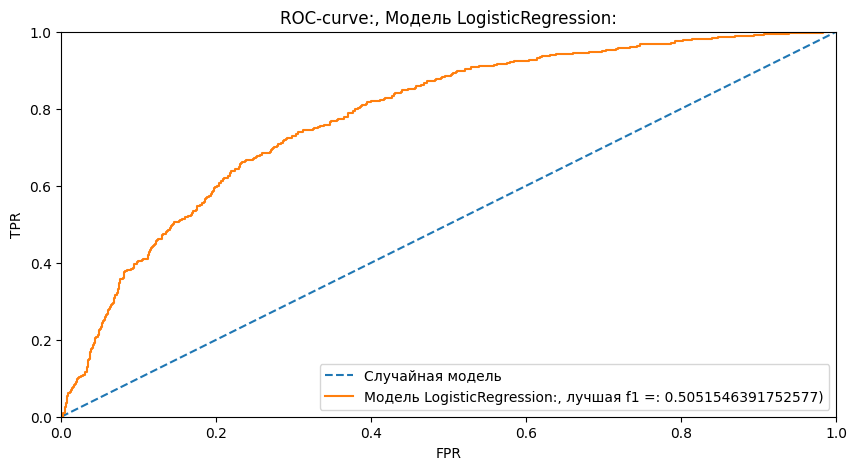

-------------------------
-------------------------
Лучшая модель: Модель RandomForest:
Значение f1-меры: 0.6527196652719665
Порог: 0.4
Площадь под кривой:, 0.8705091018819588


In [43]:
tresholds = np.arange(0.2, 0.9, 0.1)
f1_best_model = 0
best_treshold_model = 0

for num, model in enumerate(best_models):
    best_f1 = 0
    
    if num == 0:
        name = 'Модель DecisionTree:'
        print(name)
        valid = valid_list[1]
        model_prob_tree = model.predict_proba(valid[0])
        model_one_prob = model_prob_tree[:,1]
        
    elif num == 1:
        name = 'Модель RandomForest:'
        print(name)
        valid = valid_list[2]
        model_prob_forest = model.predict_proba(valid[0])
        model_one_prob = model_prob_forest[:,1]
    else:
        name = 'Модель LogisticRegression:'
        print(name)
        valid = valid_list[1]
        model_prob_logistic = model.predict_proba(valid[0])
        model_one_prob = model_prob_logistic[:,1]
    
    
    # Переберем разные пороговые значения
    for treshold in tresholds:
        model_pred_tresh = model_one_prob > treshold
        f1_model = f1_score(valid[1], model_pred_tresh)
        fpr, tpr, thresholds = roc_curve(valid[1], model_one_prob)
        auc_roc = roc_auc_score(valid[1], model_one_prob)
        print(f'Порог: {treshold:.1f}, значение f1-меры: {f1_model:.4f}')
        
    # Лучшие показатели внутри модели
        if f1_model > best_f1:
            best_f1 = f1_model
            best_treshold = treshold
     
    # Самая лучшая модель
        if best_f1 > f1_best_model:
            f1_best_model = best_f1
            best_model = model
            best_name = name
            best_treshold_model = best_treshold
            best_auc = auc_roc
    print(f'Лучшее значение f1-меры: {best_f1}, лучший порог: {best_treshold:.1f}')
    print(f'Площадь под кривой:, {auc_roc}')
# Построим ROC - кривые

    fig,ax = plt.subplots(figsize= (10,5))
    
    # ROC-curve Случайной модели
    ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label = 'Случайная модель',ls = '--')
    
    # ROC-curve лучших моделей
    ax.plot(fpr,
            tpr,
            label = f'{name}, лучшая f1 =: {best_f1})')
    ax.legend()
    ax.set_title(f'ROC-curve:, {name}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    plt.show()
    
    print('-'*25)
print('-'*25)
print(f'Лучшая модель: {best_name}')
print(f'Значение f1-меры: {f1_best_model}')
print(f'Порог: {best_treshold_model:.1f}')
print(f'Площадь под кривой:, {best_auc}')

**Лучшая модель**  

Сдвигая порог классификации выяснили, что наилучшее значение f1 - меры выдает RandomForest (обучаясь на выборках с заменой пропусков на median())

Лучшая модель: Модель RandomForest:  
Значение f1-меры: 0.6527196652719665  
Порог: 0.4  
Площадь под кривой:, 0.8705091018819588


In [44]:
# Лучшие показатели разных моделей

df_best_models = pd.DataFrame(index = ['DecisionTree', 'RandomForest', 'LogisticRegression'], columns = ['Лучшие гиперпараметры', 'Обучающие данные', 'Обработка пропусков', 'f1-мера', 'AUC', 'Порог'])

In [45]:
df_best_models.loc[:, 'Лучшие гиперпараметры'] = best_grid_tree.best_params_, best_grid_forest.best_params_, best_grid_logistic.best_params_
pd.set_option('display.max_colwidth', None)
df_best_models.loc[:, 'Обучающие данные'] = 'Downsampling', 'Balanced(Исходные)', 'Balanced(Исходные)'
df_best_models.loc[:, 'Обработка пропусков'] = 'Замена на min', 'Замена на median', 'Замена на min'
df_best_models.loc[:, 'f1-мера'] = 0.5695, 0.6527, 0.5051
df_best_models.loc[:, 'AUC'] = 0.8248, 0.8705, 0.7803
df_best_models.loc[:, 'Порог'] = 0.6, 0.4, 0.5
df_best_models

#df_best_models

,Лучшие гиперпараметры,Обучающие данные,Обработка пропусков,f1-мера,AUC,Порог
DecisionTree,{'max_depth': 4},Downsampling,Замена на min,0.5695,0.8248,0.6
RandomForest,"{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}",Balanced(Исходные),Замена на median,0.6527,0.8705,0.4
LogisticRegression,"{'class_weight': 'balanced', 'max_iter': 600, 'solver': 'lbfgs'}",Balanced(Исходные),Замена на min,0.5051,0.7803,0.5


#### Тестирование лучшей модели.

In [46]:
# Соберем тестовые выборки

test_list = [
    [features_dropna_test,
    target_dropna_test],
    
    [features_min_test,
    target_min_test],
    
    [features_median_test,
    target_median_test]
]

С Удалением пропусков
f-1 мера Лучшей модели: 0.7573333333333334
AUC Лучшей модели: 0.9268681776890887


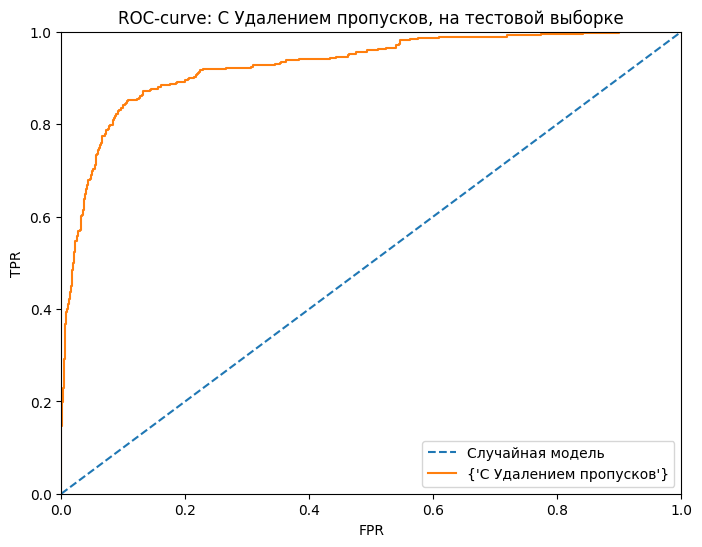

Замена пропусков на min()
f-1 мера Лучшей модели: 0.5784061696658097
AUC Лучшей модели: 0.8508369694810373


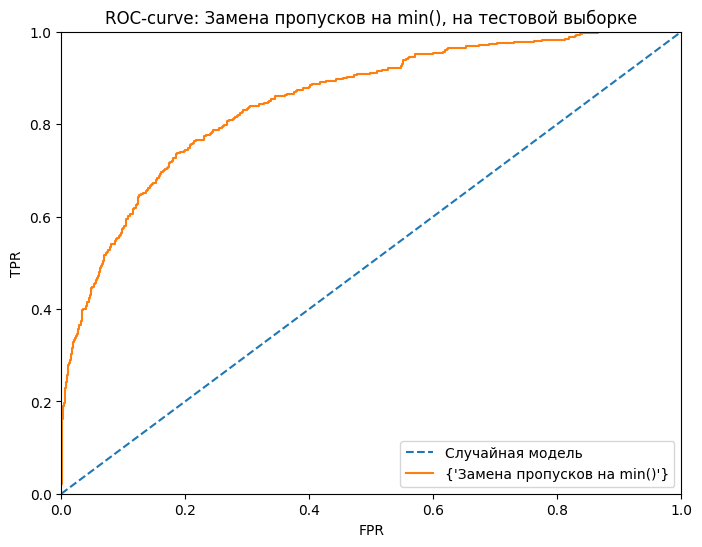

Замена пропусков на  median()
f-1 мера Лучшей модели: 0.5813060179257361
AUC Лучшей модели: 0.851783987377208


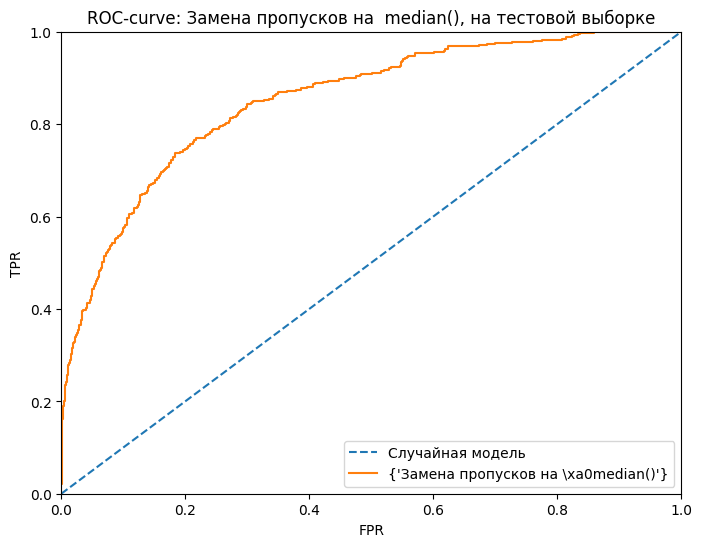


-------------------------
f1-мера лучшей модели: 0.7573333333333334
AUC лучшей модели: 0.9268681776890887
Обработка пропусков: С Удалением пропусков


In [47]:
# Тестирование лучшей модели

f1_best = 0

for num, test in enumerate (test_list):
    if num == 0:
        name = 'С Удалением пропусков'
        print(name)
    elif num == 1:
        name = 'Замена пропусков на min()'
        print(name)
    elif num == 2:
        name = 'Замена пропусков на  median()'
        print(name)
    features = test[0]  
    target = test[1]
        
  
    best_model_pred = best_model.predict(features)
    f1_best_model = f1_score(target, best_model_pred)
    
    # Посчитаем вероятности классов
    best_model_prob = best_model.predict_proba(features)
    
    # Вероятности положительно класса
    best_model_prob_one = best_model_prob[:,1]
    
    # FPR и TPR, Площадь под кривой
    fpr, tpr, thresholds = roc_curve(target, best_model_prob_one)
    auc_roc = roc_auc_score(target, best_model_prob_one)
    print(f'f-1 мера Лучшей модели: {f1_best_model}')
    print(f'AUC Лучшей модели: {auc_roc}')
    
    # Построим ROC-curve
    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'ROC-curve: {name}, на тестовой выборке')
    ax.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), label = 'Случайная модель', ls='--')
    ax.plot(fpr, tpr,
           label = {name})
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.legend()
    plt.show()
    
    if f1_best_model > f1_best:
        f1_best = f1_best_model
        best_name = name
        best_auc = auc_roc
print()        
print('-'*25)
print(f'f1-мера лучшей модели: {f1_best}')
print(f'AUC лучшей модели: {best_auc}')
print(f'Обработка пропусков: {best_name}')

---

##  Вывод

В этом проекте было нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.  
  
  
Глядя на корреляцию признаков сделали предварительно выводы о том, что именно влияет на уход клиента из банка:  
- **Кредитный рейтинг:** Много зслучаев оттока клиентов при низком кредитном рейтинге и при уровне зарплаты выше среднего.  
- **Страна проживания:** В Германии отток больше чем где бы то ни было. Это свойственно для разных значений уровня зарплаты, Во Франции отток происходит только в определенной категории клиентов с определенным показателем зарплаты В Испании - меньше всего.
- **Возраст:** Отток клиентов чаще всего происходит в Категории клиентов в возрасте от 45 - 60 лет.
- **Количество продуктов:** От этого тоже зависит отток! Чем больше продуктов, тем более вероятен уход клиента. (Если клиент пользуется 3 или 4 продуктами банка, то вероятность оттока будет максимальной).  

С помощью моделей машинного обучения построили предсказания Уйдет клиент или нет.  

- Помимо f1 - меры для определения качества модели использовали ROC-curve и AUC-ROC  
- В этом проекте Лучшие значения f1-меры и auc_roc(Площадь под кривой) - у модели RandomForestClassifier  
- Лучшие показатели f1 меры на тестовой выборке у RandomForest c гиперпараметром  
**class_weight = 'balanced'**
- Оптимальный способ обработки пропусков - **Удаление**.  
- **f1 - мера** лучшей модели на тестовой выборке сосавило **0.7573**  
- **AUC ROC** лучшей модели **0.9268**  